# Conditional Adversial Neural Network (CGAN)

Till now we have seen how to generate images using GANs. But what if we want to generate images of a specific type? For example, we want to generate images of a specific digit. In such cases, we can use Conditional GANs (CGANs). In CGANs, we provide the generator and discriminator with additional information, called the condition, which helps them to generate images of a specific type.

For example let's say we want to generate images of digit 5. In this case, we can provide the generator and discriminator with the label of digit 5. The generator will generate images of digit 5 and the discriminator will classify the images as real or fake.

How we will provide the label to the generator and discriminator? We will concatenate the label with the noise vector and provide it as input to the generator. Similarly, we will concatenate the label with the image and provide it as input to the discriminator. 

And label is converted to one-hot encoded vector. For example, if the label is 5, then it will be converted to [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]. 

And we use nn.Embedding layer to represent the label. nn.Embedding is similar to nn.Linear layer. It takes the label as input and returns the corresponding embedding vector.

For example, if the label is 5, then the embedding layer will return the embedding vector of 5. This embedding vector is then concatenated with the noise vector and provided as input to the generator. Similarly, the embedding vector is concatenated with the image and provided as input to the discriminator. 

Example:
- Generator input: [noise vector, label]
- Discriminator input: [image, label]

Video Reference: https://www.youtube.com/watch?v=Snqb7Usrauw

nn.Embedding in PyTorch is a layer that maps integer indices to dense vectors of fixed size (embeddings). Each integer index corresponds to a unique embedding vector.

When you're using nn.Embedding in the context of CGANs, you're essentially providing the label (which is typically represented as an integer index) to the nn.Embedding layer, and it returns the corresponding embedding vector for that label.

So, to correct the statement: nn.Embedding provides the embedding vector, not the label itself. When you pass a label (as an integer index) to the nn.Embedding layer, it returns the embedding vector associated with that label.

For example, if you have a label "5" which corresponds to the integer index 5, you pass this index to the nn.Embedding layer, and it returns the embedding vector for the label "5". This embedding vector is then concatenated with other inputs (like noise vector for the generator or image for the discriminator) in the CGAN architecture.

In summary, nn.Embedding is used to map integer indices (labels) to dense embedding vectors in CGANs.



In the context of an embedding layer like nn.Embedding in PyTorch, the embedding size refers to the dimensionality of the dense embedding vectors that represent each label.

When you define the embedding layer, you specify the number of classes (or unique labels) and the size of the embedding vectors. The size of the embedding vectors is a hyperparameter that you set based on the complexity of the problem and the size of the embedding space you want to create.

For example, in the code snippet provided:

embedding_size = 100
embedding_layer = nn.Embedding(num_classes, embedding_size)

Here, embedding_size is set to 100, which means each label will be represented by a dense vector of size 100. This means that the embedding layer will learn a 100-dimensional embedding space where each dimension captures certain features or characteristics of the corresponding label.



In [575]:
import torch
import torch.nn as nn

In [576]:
# Generator
class Generator(nn.Module):
    def __init__(self,latent_dim=100,img_channels=1,num_classes=10,hidden_dim=64):
        """
        Explanation:
        What is the use of latent_dim, img_channels and hidden_dim?
        - latent_dim: The dimension of the latent space. This is the dimension of the input to the generator. This is the dimension of the noise vector that is input to the generator. This is a hyperparameter that can be tuned to get better results.
        - img_channels: The number of channels in the input image. This is the number of channels in the input image that is to be generated by the generator. This is based on the dataset that is being used. For example, for grayscale images, this will be 1 and for RGB images, this will be 3.
        - hidden_dim: The number of hidden units in the generator. This is the number of hidden units in the generator that are used to generate the output image. This is a hyperparameter that can be tuned to get better results.
        """
        super(Generator,self).__init__()
        self.latent_dim = latent_dim # We are adding num_classes to the latent_dim to get the final latent_dim. This is done because we are adding the class information to the noise vector.
        self.gen_model = nn.Sequential(
            self._gen_block(self.latent_dim,hidden_dim*4), # Let's say the dimension of the input noise vector is 100 and the hidden_dim is 64. Then, the output of this layer will be of size 64*4=256.
            self._gen_block(hidden_dim*4,hidden_dim*2,kernel_size=4,stride=1),
            self._gen_block(hidden_dim*2,hidden_dim),
            self._gen_block(hidden_dim,img_channels,kernel_size=4,final_layer=True)
        )

    def _gen_block(self,input_channels,output_channels,kernel_size=3,stride=2,final_layer=False): 
        """
        Explanation:
        What is the use of kernel_size and stride?
        - kernel_size: The size of the kernel to be used in the convolution operation. This is the size of the filter that will be applied to the input image.
        - stride: The stride of the convolution operation. This is the number of pixels by which the kernel moves in each step. In case of ConvTranspose2d, this is the number of times by which the output image dimensions will be increased. For example, if the stride is 2, the output image dimensions will be twice the input image dimensions.
        """
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True) # inplace=True means that the operation will be done in place, i.e., the output will be stored in the same memory location as the input. This is done to save memory.
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.Tanh()
            )

    def forward(self,noise):
        """
        Explanation:
        Forward pass through the generator network.
        We are reshaping the noise vector to a 4D tensor of shape (batch_size,latent_dim,1,1) so that it can be passed through the generator network.
        Why are we reshaping the noise vector to a 4D tensor?
        - The input to the generator is a 4D tensor of shape (batch_size,channels,height,width). So, we need to reshape the noise vector to a 4D tensor so that it can be passed through the generator network.

        Why are height and width 1?
        - The height and width are 1 because the input to the generator is a noise vector. So, the height and width are 1.
        """
        x = noise.view(len(noise),self.latent_dim,1,1)
        return self.gen_model(x)


Why did we use stride 1 initially and then changed to 2?

The choice of stride in convolutional layers affects the spatial dimensions of the feature maps produced after convolution. Here's why the stride is set to 1 initially and then changed to 2 in subsequent layers in the generator network:

Initial Layer with Stride 1:
When the stride is set to 1, the convolutional operation moves the filter/kernel one pixel at a time across the input feature map. This results in output feature maps with the same spatial dimensions as the input feature maps but potentially with different channel dimensions due to the number of output filters.
Setting the stride to 1 in the initial layer helps preserve the spatial information of the input noise vector. Since the initial noise vector typically contains low-level features or patterns that are important for generating the overall structure of the output image, preserving spatial details in the early stages of generation can be beneficial.
Subsequent Layers with Stride 2:
As the generator network progresses through its layers, it aims to learn increasingly abstract and high-level features. Using a stride of 2 in subsequent layers reduces the spatial dimensions of the feature maps while increasing the number of channels, effectively "zooming out" and capturing broader patterns and structures in the data.
By reducing the spatial dimensions with larger strides, the generator can focus on capturing higher-level semantic information and global context, which are crucial for generating coherent and realistic images.
Additionally, increasing the stride in deeper layers can help control the growth of computational complexity and memory requirements, as it reduces the spatial resolution of feature maps and hence the number of parameters in subsequent layers.

In [577]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self,img_channels=1,num_classes=10,hidden_dim=64):
        """
        Explanation:
        What is the use of img_channels and hidden_dim?
        - img_channels: The number of channels in the input image. This is the number of channels in the input image that is to be generated by the generator. This is based on the dataset that is being used. For example, for grayscale images, this will be 1 and for RGB images, this will be 3.
        - hidden_dim: The number of hidden units in the discriminator. This is the number of hidden units in the discriminator that are used to classify the input image as real or fake. This is a hyperparameter that can be tuned to get better results.
        """
        super(Discriminator,self).__init__()
        self.img_channels = img_channels # We are adding num_classes to the img_channels to get the final img_channels. This is done because we are adding the class information to the input image.
        self.disc_model = nn.Sequential(
            self._disc_block(self.img_channels,hidden_dim), # Let's say the dimension of the input image is 1 and the hidden_dim is 64. Then, the output of this layer will be of size 64.
            self._disc_block(hidden_dim,hidden_dim*2,), # The output of this layer will be of size 64*2=128.
            self._disc_block(hidden_dim*2,1,final_layer=True), # The output of this layer will be of size 1.
        )

    def _disc_block(self,input_channels,output_channels,kernel_size=4,stride=2, final_layer = False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2,inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride),
            )
        
    def forward(self,image_vector):
        """
        Explanation:
        Forward pass through the discriminator network.
        """
        disc_output = self.disc_model(image_vector)
        return disc_output.view(len(disc_output),-1)
        # The output of the discriminator is a 2D tensor of shape (batch_size,1). So, we are reshaping it to a 1D tensor of shape (batch_size,) so that it can be used to calculate the loss.
        # How is output of the discriminator a 2D tensor of shape (batch_size,1)?
        # - The output of the discriminator is a 2D tensor of shape (batch_size,1) because the discriminator is a binary classifier. It classifies the input image as real or fake. So, the output will be a 2D tensor of shape (batch_size,1) where each element in the tensor will be the probability of the input image being real or fake.

In [578]:
def create_noise_vector(batch_size,latent_dim,device):
    """
    Explanation:
    This function is used to create a noise vector of size (batch_size,latent_dim,1,1) that is used as input to the generator.
    """
    return torch.randn(batch_size,latent_dim,device=device)

In [579]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def plot_images_from_tensor(tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    """
    Explanation:
    This function is used to plot the images generated by the generator.
    """
    tensor = tensor.detach().cpu() # detach() is used to remove the tensor from the computation graph. This is done to save memory.
    tensor = tensor.view(-1, *size) # .view() is used to reshape the tensor to the specified dimensions.
    grid = make_grid(tensor, nrow=nrow) # make_grid() is used to create a grid of images.
    plt.figure(figsize=(10, 10)) # figsize is used to set the size of the figure.
    plt.imshow(grid.permute(1, 2, 0)) # .permute() is used to change the dimensions of the tensor. Here, we are changing the dimensions from (C, H, W) to (H, W, C). This is done because plt.imshow() expects the dimensions to be (H, W, C) but the tensor is of the shape (C, H, W).
    plt.axis('off') # This is used to turn off the axis.
    if show: 
        plt.show()

In [580]:
def initialize_weights(model):
    """
    Explanation:
    This function is used to initialize the weights of the model. 
    If the module is a Conv2d or ConvTranspose2d layer, the weights are initialized using a normal distribution with mean 0 and standard deviation 0.02.
    If the module is a BatchNorm2d layer, the weights are initialized using a normal distribution with mean 0 and standard deviation 0.02 and the bias is initialized to 0.

    What is the use of nn.init.normal_ and nn.init.constant_?
    - nn.init.normal_: This is used to initialize the weights of the module using a normal distribution.
    - nn.init.constant_: This is used to initialize the bias of the module to a constant value.

    What is bias in a neural network?
    - Bias is a constant value that is added to the weighted sum of the inputs to the neuron. It allows the neuron to learn the optimal function that maps the input to the output.

    Why are we making the bias zero?
    - We are making the bias zero to ensure that the initial output of the neuron is close to zero. This helps in training the model faster as the gradients will not be too large.
    """
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight,0.0,0.02)
            nn.init.constant_(m.bias,0)

In [581]:
def get_one_hot_encoded_vector_for_labels(labels,num_classes):
    """
    Explanation:
    This function is used to convert the labels to one-hot encoded vectors.

    What is the use of one-hot encoding and why are we using it here?
    - One-hot encoding is used to represent categorical data as binary vectors. It is used to convert the labels to a format that can be used as input to the neural network. In this case, we are using it to convert the labels to a format that can be used as input to the generator.

    For example:
    x = torch.tensor([0, 1, 2, 1])
    num_classes = 3

    Result:
    tensor([[1, 0, 0],
            [0, 1, 0],
            [0, 0, 1],
            [0, 1, 0]])

    What does this result mean?
    - The first label is 0, so the one-hot encoded vector is [1, 0, 0].
    - The second label is 1, so the one-hot encoded vector is [0, 1, 0].
    - The third label is 2, so the one-hot encoded vector is [0, 0, 1].
    - The fourth label is 1, so the one-hot encoded vector is [0, 1, 0].
    """
    return torch.nn.functional.one_hot(labels,num_classes)


In [582]:
def concatenate_vecs(x,y):
    """
    Explanation:
    This function is used to concatenate the noise vector x and the one-hot encoded vector y.

    Why are we concatenating the noise vector and the one-hot encoded vector?
    - We are concatenating the noise vector and the one-hot encoded vector to create a single input vector that can be used as input to the generator. This is done to generate images based on the noise vector and the class label.

    For example:
    x = torch.tensor([[1, 2, 3], [4, 5, 6]])
    y = torch.tensor([[7, 8], [9, 10]])

    Result:
    tensor([[ 1.,  2.,  3.,  7.,  8.],
            [ 4.,  5.,  6.,  9., 10.]])

    What does this result mean?
    - The first row of the result is the concatenation of the first row of x and the first row of y.
    - The second row of the result is the concatenation of the second row of x and the second row of y.

    Why are converting x and y to float?
    - We are converting x and y to float to ensure that the input to the generator is of the correct data type. The generator expects the input to be of type float.

    Why are we concatenating along dim=1?
    - We are concatenating along dim=1 to concatenate the vectors along the columns. This is done to create a single input vector that can be used as input to the generator.

    Rules of concatenation:
    - The dimensions of the input tensors should be the same except for the dimension along which they are concatenated.
    - The dimensions of the input tensors along the concatenation dimension should be the same.
    """
    return torch.cat((x.float(),y.float()),dim=1)

In [583]:
# hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_dim = 64 # dimension of the noise vector
img_channels = 1 # number of channels in the input image (1 for grayscale, 3 for RGB)
num_classes = 10 # number of classes in the dataset (MNIST has 10 classes, from 0 to 9)
lr = 2e-4 # learning rate
batch_size = 128 # batch size for training the model
num_epochs = 50 # number of epochs for training the model

In [584]:
# Initialize the generator and discriminator

generator_latent_dim = latent_dim + num_classes # dimension of the input to the generator
discriminator_img_channels = img_channels + num_classes # dimension of the input to the discriminator

gen = Generator(latent_dim=generator_latent_dim,img_channels=img_channels).to(device)
disc = Discriminator(img_channels=discriminator_img_channels).to(device)

In [585]:
# Initialize the weights of the generator and discriminator
gen.apply(initialize_weights)
disc.apply(initialize_weights)

Discriminator(
  (disc_model): Sequential(
    (0): Sequential(
      (0): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
    )
  )
)

In [586]:
# Loss function
criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy with Logits Loss is used as the loss function

# What is the meaning of Logits loss in PyTorch?
# - Logits loss is a loss function that is used to calculate the loss between the predicted values and the actual values. It is used when the output of the model is not normalized and the values are not between 0 and 1.

# Optimizers
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.999)) # Adam optimizer is used for training the generator
disc_opt = torch.optim.Adam(disc.parameters(),lr=lr,betas=(0.5,0.999)) # Adam optimizer is used for training the discriminator

In [587]:
# Load the MNIST dataset
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
]) # Normalize the pixel values to be between -1 and 1

mnist_data = datasets.MNIST(root='./data',train=True,download=True,transform=transform) # Load the MNIST dataset
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,batch_size=batch_size,shuffle=True) # Create a data loader

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0: Step 0: Generator loss: 0.6954718828201294, Discriminator loss: 0.6931466460227966


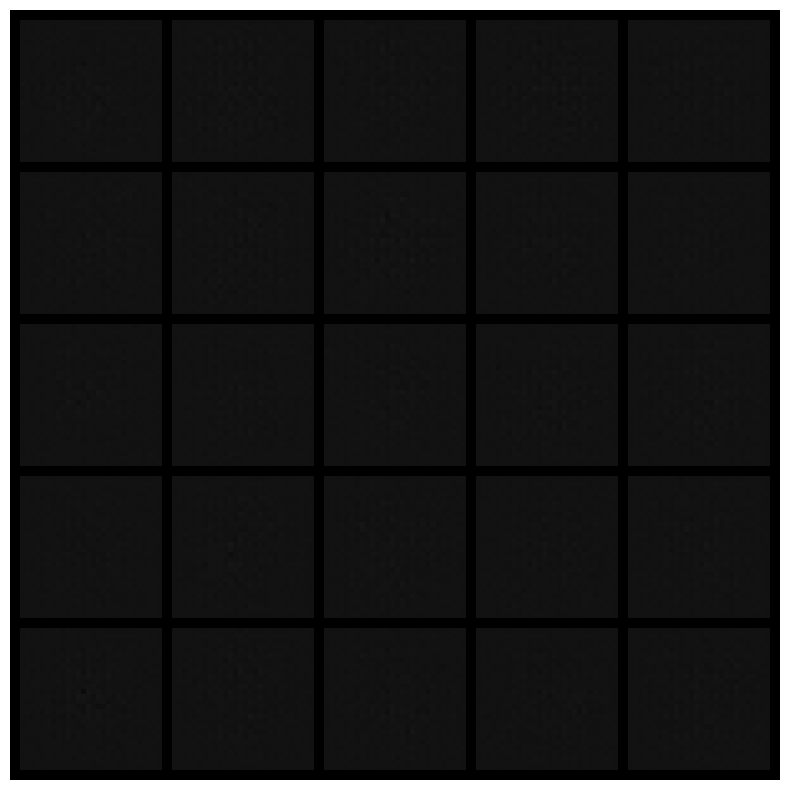

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


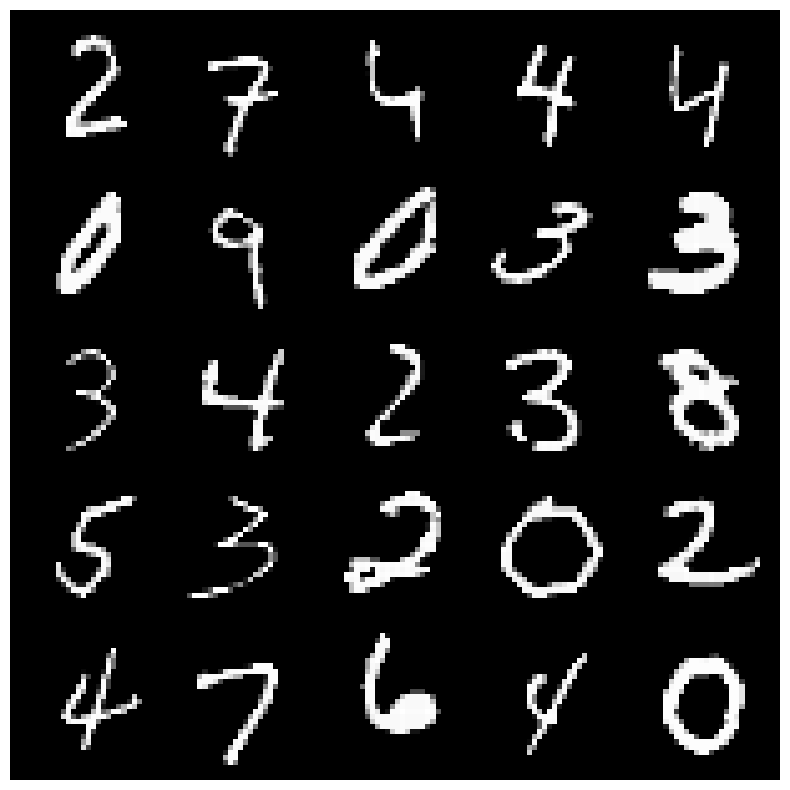

  7%|▋         | 31/469 [00:11<02:29,  2.94it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1: Step 500: Generator loss: 3.2880125045776367, Discriminator loss: 0.04979769140481949


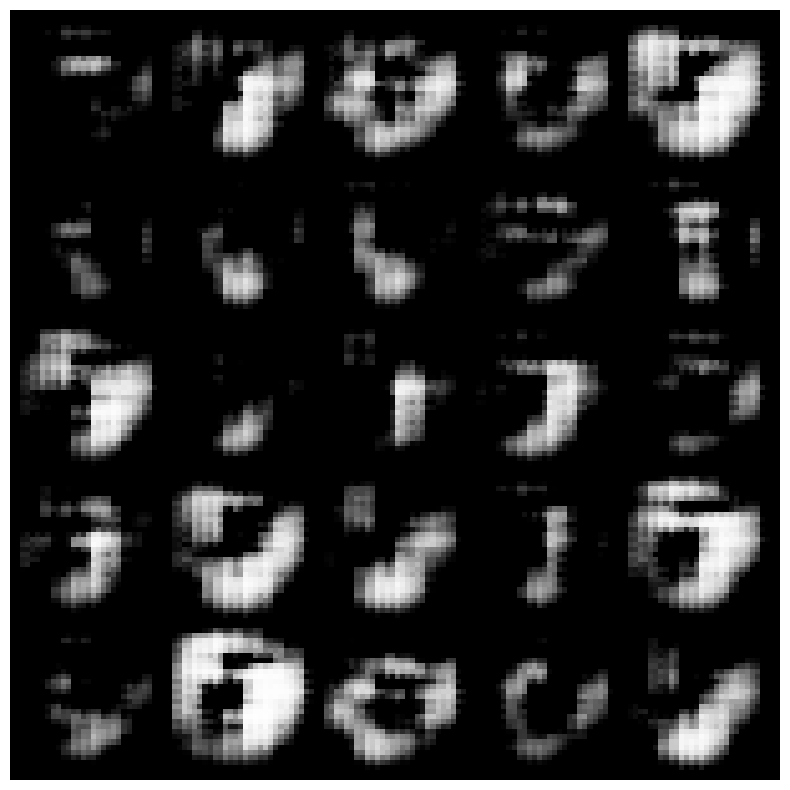

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


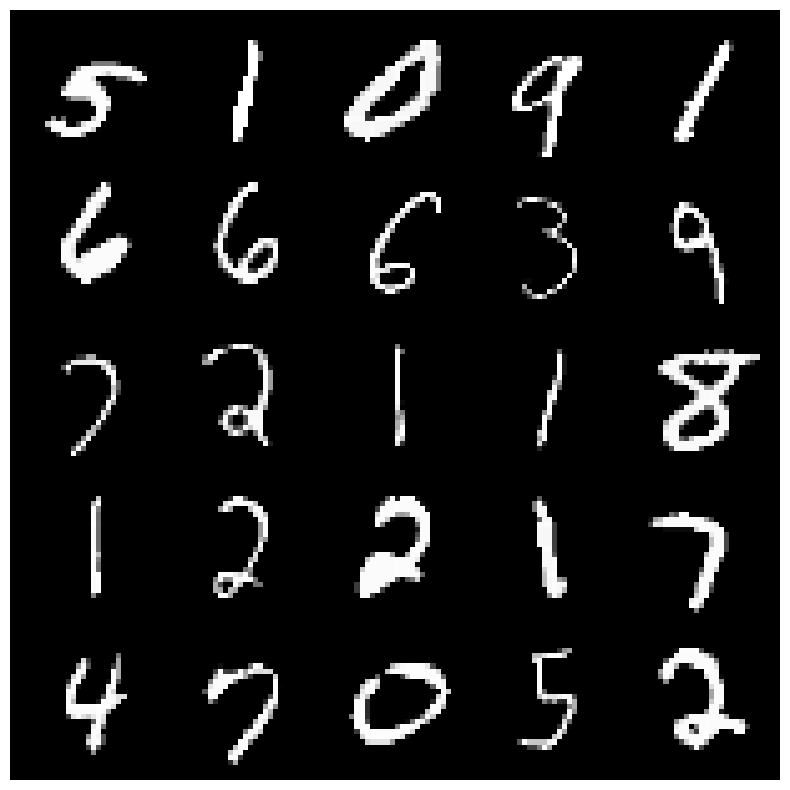

 13%|█▎        | 62/469 [00:21<02:16,  2.99it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2: Step 1000: Generator loss: 1.0977234840393066, Discriminator loss: 0.5475831627845764


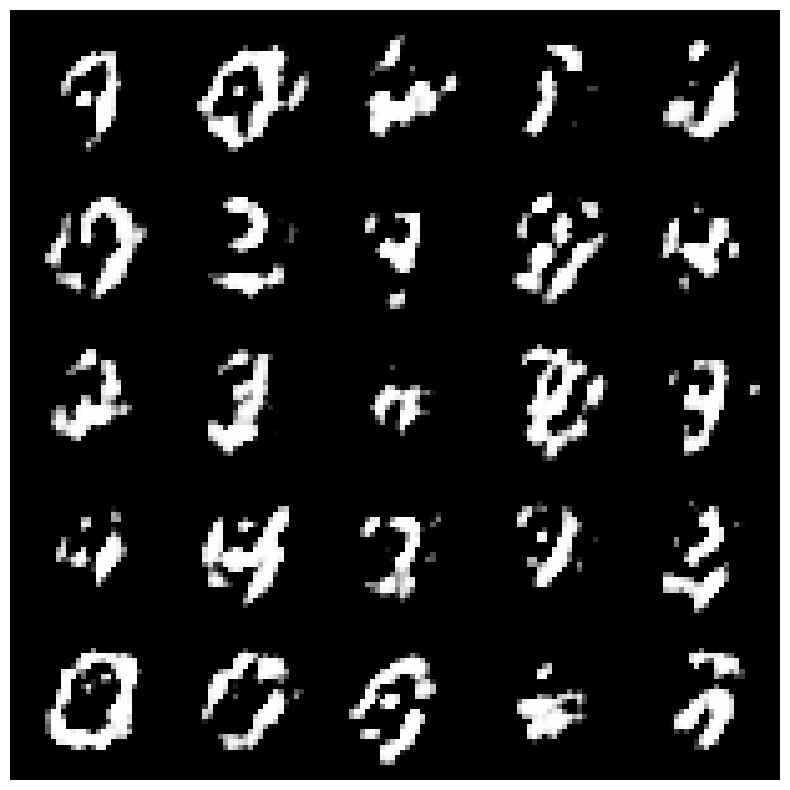

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


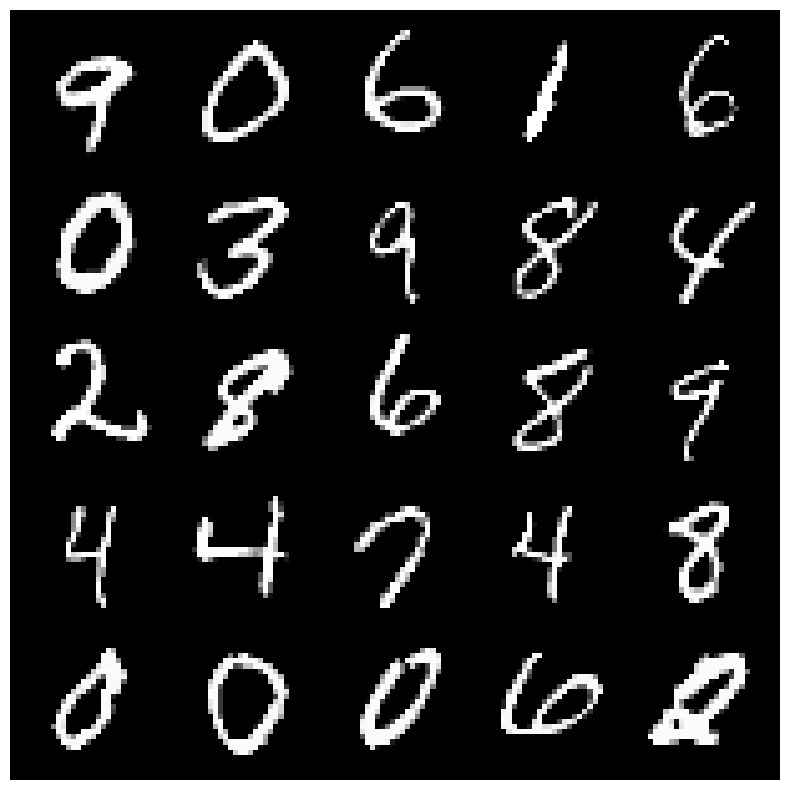

 20%|█▉        | 93/469 [00:34<02:19,  2.69it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3: Step 1500: Generator loss: 1.292373776435852, Discriminator loss: 0.456718385219574


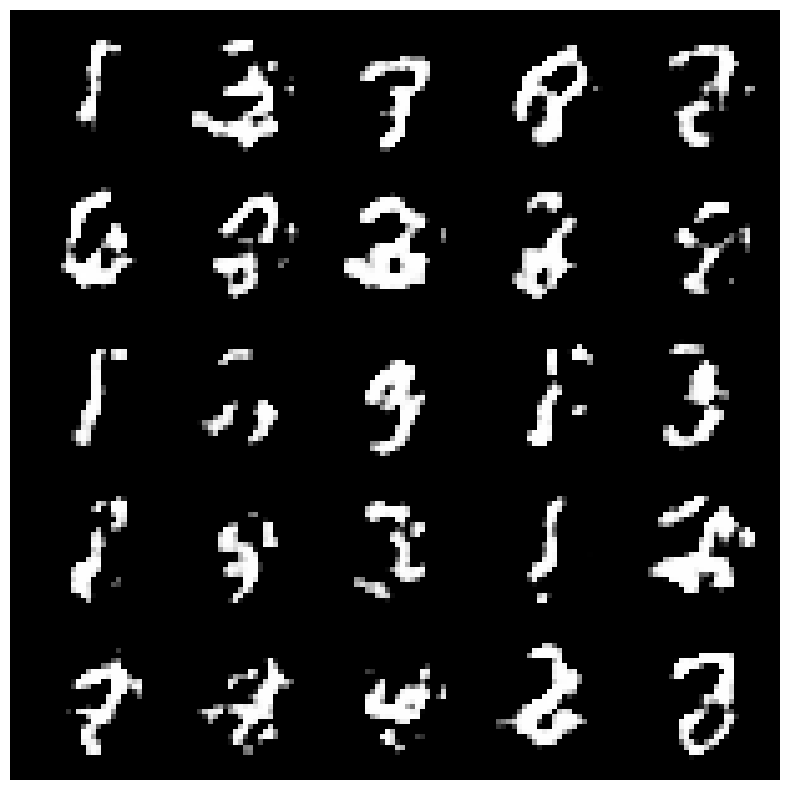

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


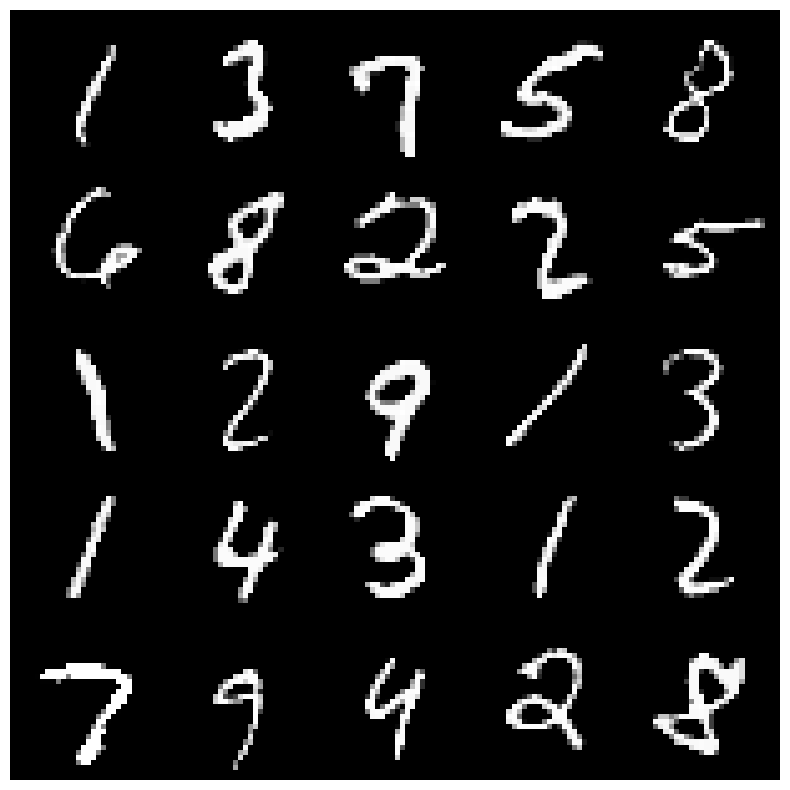

 26%|██▋       | 124/469 [00:50<02:06,  2.73it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4: Step 2000: Generator loss: 1.391782522201538, Discriminator loss: 0.5367611050605774


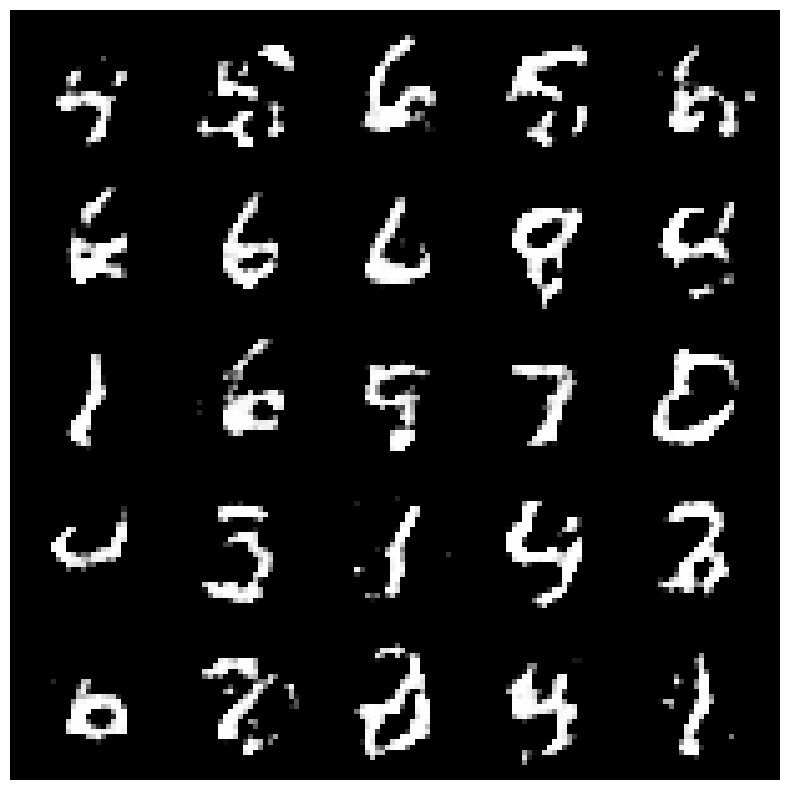

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


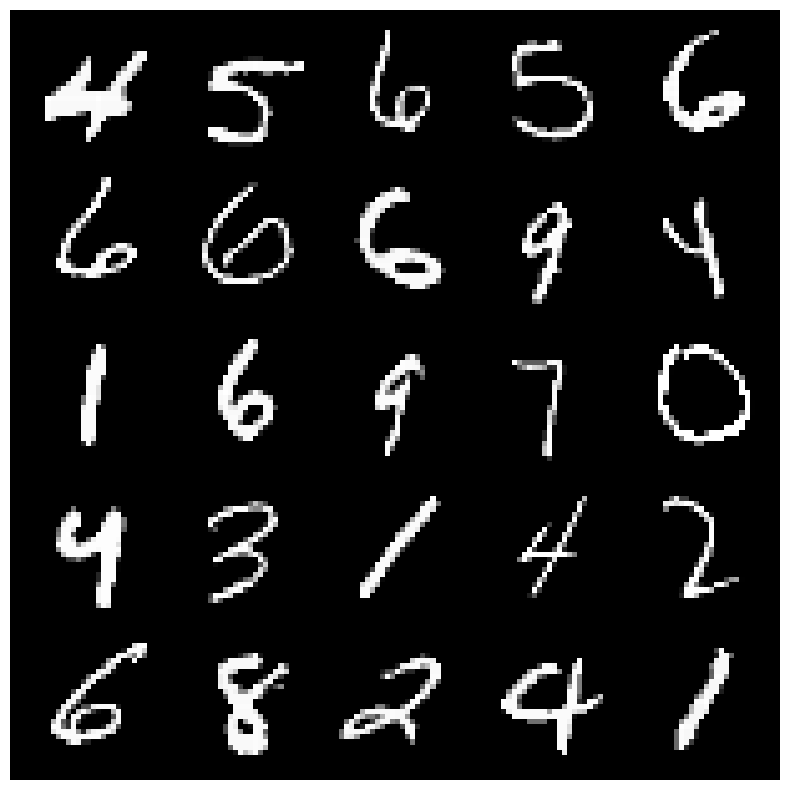

  0%|          | 0/469 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [588]:
from tqdm import tqdm

current_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(num_epochs):
    for real,labels in tqdm(data_loader):
        current_batch_size = len(real)
        real_images = real.to(device) # Move the real images to the device

        # Convert the labels to one-hot encoded vectors
        one_hot_encoded_labels = get_one_hot_encoded_vector_for_labels(labels,num_classes).to(device) # Convert the labels to one-hot encoded vectors
    
        # reshape the image labels to the shape of the input image which is (batch_size,num_classes,28,28) in this case for MNIST
        img_one_hot_encoded_labels = one_hot_encoded_labels.view(current_batch_size,num_classes,1,1)
        img_one_hot_encoded_labels = img_one_hot_encoded_labels.repeat(1,1,28,28) # repeat the labels along the height and width dimensions to match the shape of the input image
        """
        Breaking down the above code:
        - one_hot_encoded_labels.view(current_batch_size,num_classes,1,1): This reshapes the one-hot encoded labels to the shape (batch_size,num_classes,1,1).
        - img_one_hot_encoded_labels.repeat(1,1,28,28): This repeats the one-hot encoded labels along the height and width dimensions to match the shape of the input image. The resulting shape will be (batch_size,num_classes,28,28).

        1. Reshaping the Labels Tensor:
        Initially, the labels tensor has a shape of (batch_size, num_classes), where batch_size is the number of samples in the batch, and num_classes is the number of classes or categories.
        To make the labels tensor compatible with the image tensor, which typically has dimensions (batch_size, channels, height, width), we reshape the labels tensor to have dimensions (batch_size, num_classes, 1, 1).
        This reshaping essentially adds two extra dimensions to the labels tensor, turning it into a 4D tensor where each label becomes a "channel" in the spatial dimensions.
        
        2. Repeating Along Height and Width:
        Since the labels tensor has been reshaped to match the spatial dimensions of the image tensor, we now need to ensure that the labels are repeated across the entire spatial extent of each image.
        To achieve this, we use the repeat() function to repeat the labels along the height and width dimensions of the image tensor.
        For example, if the original images have spatial dimensions of 28x28, and we want each label to cover the entire spatial area of the corresponding image, we repeat the labels tensor 28 times along both the height and width dimensions.
        This ensures that each pixel in the generated image is associated with the appropriate label, allowing the discriminator network to learn to distinguish between different classes at each spatial location.
        """

        ##########################
        # Train the discriminator #
        ##########################

        disc_opt.zero_grad()

        # Generate noise vector for the current batch and concatenate it with the one-hot encoded labels
        fake_noise = create_noise_vector(current_batch_size,latent_dim,device)
        fake_noise_with_labels = concatenate_vecs(fake_noise,one_hot_encoded_labels)

        # Get the fake images from the generator
        fake_images = gen(fake_noise_with_labels)

        # Check if the length of the fake images is the same as the batch size
        assert len(fake_images) == len(real_images)

        # Get the predictions for the fake images
        # 1. Create input for the discriminator
        disc_input_with_labels = concatenate_vecs(fake_images,img_one_hot_encoded_labels)
        # 2. Get the predictions for the fake images
        disc_fake_pred = disc(disc_input_with_labels.detach()) # detach() is used to remove the tensor from the computation graph. This is done to save memory. We dont need to update the weights of the generator here.
        disc_real_pred = disc(concatenate_vecs(real_images,img_one_hot_encoded_labels))

        # Calculate the loss for the discriminator
        disc_fake_loss = criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred,torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Update the weights of the discriminator
        disc_loss.backward()
        disc_opt.step()

        ######################
        # Train the generator #
        ######################
        gen_opt.zero_grad()

        # Get the predictions for the fake images
        disc_fake_pred = disc(disc_input_with_labels)

        # Calculate the loss for the generator
        gen_loss = criterion(disc_fake_pred,torch.ones_like(disc_fake_pred))

        # Update the weights of the generator
        gen_loss.backward()
        gen_opt.step()

        # Print the losses
        if current_step % 500 == 0:
            print(f"Epoch {epoch}: Step {current_step}: Generator loss: {gen_loss.item()}, Discriminator loss: {disc_loss.item()}")
            generator_losses.append(gen_loss.item())
            discriminator_losses.append(disc_loss.item())

            plot_images_from_tensor(fake_images[:25])
            plot_images_from_tensor(real_images[:25])

        current_step += 1



# Save the model
torch.save(gen.state_dict(),'generator.pth')
torch.save(disc.state_dict(),'discriminator.pth')